In [ ]:
# Este es el pipeline para la estrategia 2. Aquí trabajaremos con el 80% del dataset con el que hemos entrenado los modelos. 

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import load

In [12]:
# 1. Cargar el dataset completo
df = pd.read_csv("../data/feature_engineering.csv")

# Aplicar Transformación logarítmica a target
cols_to_transform = ['price']
df[cols_to_transform] = df[cols_to_transform].apply(np.log1p)

# 2. Separar X e y
X = df.drop(columns="price")
y_log = df["price"]

# 3. Hacer train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# 4. Cargar los modelos ya entrenados
modelo_clasificador = load("../model/Modelo2_clasificacion_rf.pkl")
modelo_regresion_barato = load("../model/Modelo3_regresion_cat_logY_split.pkl")
modelo_regresion_caro = load("../model/Modelo4_regresion_rf_logY_split.pkl")

def predecir_y_evaluar(X, y_log, clasificador, modelo_barato, modelo_caro):
    # Clasificar en barato/caro
    es_caro = clasificador.predict(X)

    # Separar subconjuntos
    X_barato = X[es_caro == 0]
    X_caro = X[es_caro == 1]

     # Predecir con los modelos que devuelven log(price)
    y_pred_barato_log = modelo_barato.predict(X_barato)
    y_pred_caro_log = modelo_caro.predict(X_caro)

    # Volver a la escala original
    y_pred_barato = np.expm1(y_pred_barato_log)
    y_pred_caro = np.expm1(y_pred_caro_log)

    # Unir predicciones
    y_pred = np.zeros(len(X))
    y_pred[es_caro == 0] = y_pred_barato
    y_pred[es_caro == 1] = y_pred_caro

    # Convertir y real a escala original también
    y = np.expm1(y_log)

    # Calcular métricas
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    return mae, rmse, r2

# Evaluar en train
mae_train, rmse_train, r2_train = predecir_y_evaluar(
    X_train, y_train_log, modelo_clasificador, modelo_regresion_barato, modelo_regresion_caro
)

# Evaluar en test
mae_test, rmse_test, r2_test = predecir_y_evaluar(
    X_test, y_test_log, modelo_clasificador, modelo_regresion_barato, modelo_regresion_caro
)

# Mostrar resultados
print("=== Métricas en TRAIN ===")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"R²: {r2_train:.3f}")

print("\n=== Métricas en TEST ===")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²: {r2_test:.3f}")



=== Métricas en TRAIN ===
MAE: 1524.15
RMSE: 3765.36
R²: 0.976

=== Métricas en TEST ===
MAE: 2457.47
RMSE: 5433.45
R²: 0.937


In [13]:
y = np.expm1(y_log)

In [14]:
y.describe()

count      8948.000000
mean      21875.137908
std       24024.610053
min        1000.000000
25%       10886.250000
50%       16490.000000
75%       24990.000000
max      449000.000000
Name: price, dtype: float64

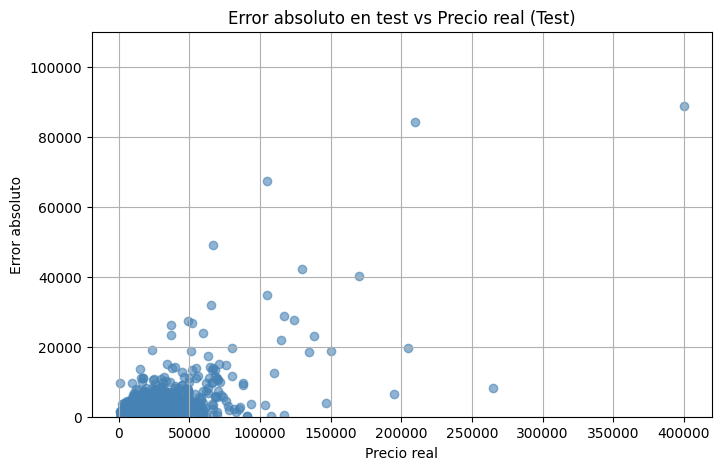

In [17]:
import matplotlib.pyplot as plt

# Repetimos lógica de predicción para obtener predicciones individuales en test

# Clasificación
es_caro_test = modelo_clasificador.predict(X_test)
X_barato_test = X_test[es_caro_test == 0]
X_caro_test = X_test[es_caro_test == 1]

# Predicción en escala log
y_pred_barato_log = modelo_regresion_barato.predict(X_barato_test)
y_pred_caro_log = modelo_regresion_caro.predict(X_caro_test)

# Volver a la escala original
y_pred_barato = np.expm1(y_pred_barato_log)
y_pred_caro = np.expm1(y_pred_caro_log)

# Unir predicciones
y_pred_test = np.empty(len(X_test))
y_pred_test[es_caro_test == 0] = y_pred_barato
y_pred_test[es_caro_test == 1] = y_pred_caro

# Convertir y_test a escala original también
y_test_original = np.expm1(y_test_log)

# Calcular errores absolutos
errores_abs_test = np.abs(y_test_original.values - y_pred_test)

# Gráfico
plt.figure(figsize=(8,5))
plt.scatter(y_test_original, errores_abs_test, alpha=0.6, c='steelblue')
plt.xlabel('Precio real')
plt.ylabel('Error absoluto')
plt.title('Error absoluto en test vs Precio real (Test)')
plt.ylim(0, 110000)  # Limitar eje Y si tiene sentido en tu dataset
plt.grid(True)
plt.show()